# Sistema de Recomendação de Animes

## Tiago de Paula Dantas da Silva

## Introdução e Motivações

Bem vindo(a) ao meu projeto final da disciplina "Computação Científica e Análise de Dados"!

Quando estava buscando um tema para realizar o projeto, queria fazer algo relacionado com NLP, e aí falando com o professor João, ele me recomendou algo chamado de "Topic Modelling", que é basicamente, uma forma de identificar tópicos em coleção de textos(iremos ver isso com mais calma brevemente).

Procurando datasets para trabalhar, dei de cara com um muito interessante sobre animes, só que eu achei que, somente fazer a divisão de tópicos dos animes, seria muito pouco. 

Sendo assim, decidi fazer um sistema de recomendação, que tenha o "Topic Modelling" como um atributo.

## Bases de dados

As bases de dados utilizadas para o sistema foram a **'anime_synopsis.csv'** e a **'anime.csv'** disponibilizadas no [Kaggle](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020), os dados foram recolhidos do site [MyAnimeList](https://myanimelist.net), em 2020.

## Como funciona o sistema?

Esse sistema de recomendação é baseado no conteúdo dos itens, ou seja, iremos utilizar somente as características e atributos dos animes para realizar a recomendação.

Mais especificamente, iremos utilizar três informações:
- Sinopse do anime
- Gêneros do anime
- Tópicos do anime (obtidos através do Topic Modelling)

A sinopse e os gêneros do anime, irão formar os atributos/características do anime, em um só texto, e a ideia é transformar esse texto em um vetor, para que possamos comparar a similaridade entre os vetores, e assim, ao mesmo tempo, a similaridade entre os animes.

Além da similaridade dos atributos, iremos levar em conta também a similaridade entre os tópicos dos animes, e a partir dessas duas informações, conseguimos realizar a recomendação de animes!

## Importações das bibliotecas utilizadas

In [1452]:
import pandas as pd
import numpy as np

import re
import unidecode
import nltk
#nltk.download("stopwords")
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from bs4 import BeautifulSoup
import requests

from PIL import Image
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

### Análise dos Datasets

In [1453]:
df = pd.read_csv('anime_with_synopsis.csv')
df.head()

,MAL_ID,Name,Score,Genres,sypnopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


O primeiro dataset que vamos utilizar é esse de cima, ele é muito importante para a nossa recomendação, já que a partir dele iremos obter as informações sobre a temática dos animes.

Obs: irei renomear a coluna 'sypnopsis', pois ela está nomeada erradamente, o certo seria 'synopsis'.

In [1454]:
df.rename(columns={'sypnopsis':'Synopsis'}, inplace=True)

In [1455]:
df2 = pd.read_csv('anime.csv')
df2.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


Esse outro dataset serve somente para utilizar algumas informações "extras" sobre o anime, não sobre sua temática, mas sobre sua distribuição.

In [1456]:
df = pd.merge(df, df2[['MAL_ID', 'Type', 'Studios', 'Aired']], on=['MAL_ID'])
df.head()

,MAL_ID,Name,Score,Genres,Synopsis,Type,Studios,Aired
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever...",TV,Sunrise,"Apr 3, 1998 to Apr 24, 1999"
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ...",Movie,Bones,"Sep 1, 2001"
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0...",TV,Madhouse,"Apr 1, 1998 to Sep 30, 1998"
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...,TV,Sunrise,"Jul 2, 2002 to Dec 24, 2002"
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...,TV,Toei Animation,"Sep 30, 2004 to Sep 29, 2005"


Esse último dataset mostrado é o que iremos utilizar até o final, suas colunas são:
- **ID**: Identificador do anime no site MyAnimeList
- **Name**: Nome do anime no site MyAnimeList
- **Score**: Avaliação do anime no site MyAnimeList
- **Genres**: Lista de gêneros do anime
- **Synopsis**: Sinopse do anime
- **Type**: Tipo do anime, isso indica se ele é uma série, um filme, um OVA e etc
- **Studios**: Estúdio que produziu o anime
- **Aired**: Data em que o anime foi exibido

Agora vamos analisar com mais calma algumas colunas e aprimorá-las.

In [1457]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16214 entries, 0 to 16213
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   MAL_ID    16214 non-null  int64 
 1   Name      16214 non-null  object
 2   Score     16214 non-null  object
 3   Genres    16214 non-null  object
 4   Synopsis  16206 non-null  object
 5   Type      16214 non-null  object
 6   Studios   16214 non-null  object
 7   Aired     16214 non-null  object
dtypes: int64(1), object(7)
memory usage: 1.1+ MB


Através da celúla acima, conseguimos obter algumas informações sobre as colunas, a primeira seria do tipo de dado que cada uma guarda e se existem valores nulos na coluna.

É possível perceber que a coluna de sinopse possui valores nulos, então temos que resolver isso, quando formos tratá-la.

### Pré-processamento das colunas

#### Score

Pela informação, do 'df.info()', a coluna 'Score' está guardando 'object', em vez de 'float', que seria o dado mais razoável para se guardar as avaliações.

Podemos investigar isso!

In [1458]:
df['Score'].value_counts()

Unknown    5123
6.45         65
6.31         64
6.52         63
6.48         61
           ... 
4.2           1
8.91          1
3.32          1
1.85          1
4.06          1
Name: Score, Length: 532, dtype: int64

Descobrimos que além das avaliações númericas, há também uma avaliação 'Unknown'.

Para o tratamento do 'Score' irei apenas, passar os valores diferentes de 'Unknown' para float, e se o valor for 'Unknown' foi transformá-lo para 0.

In [1459]:
def pre_process_score(x):
    if x=='Unknown':
        return 0
    else:
        return float(x)

In [1460]:
df['Score'] = df['Score'].apply(lambda x : pre_process_score(x))

#### Aired

O tratamento da coluna Aired, é apenas para passar as datas para um formato ANO-ANO, porque isso ajudará na filtragem dos animes recomendados.

In [1461]:
df['Aired'].value_counts()

Unknown              308
2005                  57
2004                  49
2021 to ?             46
2003                  45
                    ... 
Apr 7, 1984            1
Oct 5, 1984            1
Oct 6, 1975            1
Jul 1, 1992            1
Mar 17, 2021 to ?      1
Name: Aired, Length: 10888, dtype: int64

A função 'get_years' tenta pegar os dois anos presentes na string de exibição, se houver somente um ano, e o último caracter não for '?'(que indica que o anime ainda está sendo exibido), esse ano é repetido, mas se o último caracter for '?', uso ele como se fosse o último ano, e se não houver nenhum ano é retornado o caracter '?'.

Exemplos:
- Apr 3, 1998 to Apr 24, 1999 -> 1998-1999
- Oct 6, 1975 -> 1975-1975
- Mar 17, 2021 to ? -> 2021-?
- ? -> ?

In [1462]:
def get_years(x):
    anos = []

    tam = len(x)

    #tentando pegar os dois anos da string
    for i in range(tam-3):
        if x[i].isnumeric() and x[i+1].isnumeric() and x[i+2].isnumeric() and x[i+3].isnumeric():
            anos.append(x[i:i+4])

    #se o ultimo caracter for '?' ou se não há anos na exibição, adiciono '?' na lista de anos
    if x[tam-1] == '?' or len(anos)==0:
        anos.append('?')
    elif len(anos)==1: #se só houver um ano na string, repito ele
        anos.append(anos[0])

    anos = '-'.join(anos)

    return anos

In [1463]:
df['Aired'] = df['Aired'].apply(lambda x : get_years(x))

#### Synopsis

Precisamos dar uma olhada primeiro nos dados nulos!

In [1464]:
df_null = df[~df.index.isin(df.dropna().index)]
df_null

,MAL_ID,Name,Score,Genres,Synopsis,Type,Studios,Aired
11451,34755,Kuma no Gakkou: Patissier Jackie to Ohisama no...,0.00,"Comedy, Kids",NaN,Movie,Unknown,2017-2017
11469,34794,Yukai na Animal Bus,0.00,"Comedy, Kids",NaN,TV,TMS Entertainment,2017-2017
13686,38475,Yuru Camp△ Movie,0.00,"Comedy, Slice of Life",NaN,Movie,Unknown,?
15025,40714,Youkai Watch Jam: Youkai Gakuen Y - N to no So...,6.28,"Comedy, Demons, Kids, Supernatural, School",NaN,TV,OLM,2019-?
15747,42717,Kaeru no Pickles: Kimochi no Iro,0.00,"Slice of Life, Kids",NaN,TV,Unknown,2020-2020
16056,44848,Iii Icecrin,0.00,Kids,NaN,TV,Shin-Ei Animation,2021-?
16110,45731,Argonavis from BanG Dream! Movie,0.00,Music,NaN,Movie,Unknown,?
16120,46095,Vivy: Fluorite Eye's Song,0.00,Sci-Fi,NaN,TV,Wit Studio,2021-?


Pelo código acima, conseguimos identificar as linhas que possuem a sinopse como nula.

Irei substituir os valores por uma string vazia.

In [1465]:
df['Synopsis'] = df['Synopsis'].fillna('')

Investigando também a sinopse...

In [1466]:
df['Synopsis'].value_counts()

No synopsis information has been added to this title. Help improve our database by adding a synopsis here .                                                                                                                                                                                                                                                                                                                                                                                                                                                   709
No synopsis has been added for this series yet. Click here to update this information.                                                                                                                                                                                                                                                                                                                                                                                

Podemos perceber que na sinopse temos dados faltantes "camuflados", com sinopses começando por "No synopsis...", durante o pré processamento, irei trocar essas sinopses por uma string vazia.

Como iremos utilizar o texto da sinopse para a nossa recomendação, vou reduzi-lo para que ele só contenha as informações mais importantes da sinopse.

Sendo assim, no pré-processamento, irei realizar alguns métodos:
- Reduzir todas as letras do texto para minúsculo
- Retirar acento das palavras
- Deixar somente letras no texto, retirando pontução, números e etc
- Retirar as "stopwords" do texto, essas seriam palavras que são irrelaventes para o nosso modelo, como 'the', 'a', 'is', 'are'...
- Realizar o "Stemming" das palavras, essa técnica reduz a palavra para seu radical, então, por exemplo, verbos e substantivos serão identificados de uma mesma forma, um exemplo visual pode ser observado abaixo

#### Stemming

<img src="stemming.png" style="height:500px; width:850px;">

In [1467]:
def pre_process_synopsis(x):
    x = x.lower() #transforma todos os caracteres em minúsculo

    if 'no synopsis' in x: #se não tiver sinopse retorno uma string nula
        return ''
    
    x = unidecode.unidecode(x) #retira acento das palavras

    x = re.sub("[^a-zA-Z]", " ", x) #deixa apenas letras na string

    x = word_tokenize(x) #separa as palavras da string em uma lista

    stpw = stopwords.words("english")

    stemmer = SnowballStemmer(language="english")

    x = [stemmer.stem(word) for word in x if word not in stpw] #junta as palavras da lista que não são stopwords em uma string, além de aplicar o stemming nelas

    x = ' '.join(x)

    return x

In [1468]:
df['Synopsis'] = df['Synopsis'].apply(lambda x : pre_process_synopsis(x))

#### Genres

Realizando uma mesma investigação na coluna 'Genres'...

In [1469]:
df['Genres'].value_counts()

Music                                         790
Comedy                                        668
Kids                                          413
Kids, Music                                   234
Dementia                                      228
                                             ... 
Action, Adventure, Police, Mecha, Sci-Fi        1
Romance, Supernatural, Mystery, Vampire         1
Slice of Life, Sports, Romance, Shounen Ai      1
Action, Police, Mecha, Sci-Fi                   1
Adventure, Mystery, Supernatural                1
Name: Genres, Length: 4857, dtype: int64

Apesar de 'Unknown' não aparecer como um valor muito comum na coluna, como as outras já possuiam ele como um valor possível, resolvi ver se ele estava presente. 

In [1470]:
df[df['Genres']=='Unknown']

,MAL_ID,Name,Score,Genres,Synopsis,Type,Studios,Aired
8759,28487,Ikite Iru,0.00,Unknown,tsuyoshi year old friend play tumbl photo brea...,OVA,Unknown,1996-1996
8807,28653,Maze,0.00,Unknown,stract stop motion anim tochka,Movie,Unknown,2012-2012
8808,28655,PiKA PiKA,5.12,Unknown,stract short film first lightn doodl film tochka,Movie,Unknown,2006-2006
9049,29655,Chanda Gou,0.00,Unknown,independ anim yanagihara ryouhei member anim s...,Movie,Unknown,1964-1964
9101,29765,Metropolis (2009),5.93,Unknown,ai mizu first time experi geometr anim,Movie,Unknown,2009-2009
...,...,...,...,...,...,...,...,...
14684,40090,Sinbi Apateu: Ghost Ball X-ui Tansaeng,0.00,Unknown,,TV,Unknown,2017-2019
15028,40717,Kaiju Decode,0.00,Unknown,,Unknown,Unknown,?
15963,43762,Hula Fulla Dance,0.00,Unknown,natsunagi hiwa novic jump world hula girl sist...,Movie,Bandai Namco Pictures,2021-2021
15983,44041,SD Gundam World Heroes,0.00,Unknown,balanc world maintain hero sudden red hot mete...,TV,Unknown,2021-?


A partir da célula acima, é possível perceber que a coluna de gêneros também possui o 'Unknown', dessa forma, durante o pré-processamento irei trocá-lo por uma string vazia.

Para o tratamento dos gêneros, irei fazer o básico:
- Passar o texto para minúsculo
- Retirar acento dos gêneros
- Gêneros que possuem mais de uma palavra, irei compactar para virar uma palavra só, por exemplo, 'martial arts' irei reduzir para 'martialarts'
- Gêneros que possuem '-' para separar as palavras, irei compactar para virar uma palavra só, por exemplo 'sci-fi' irei reduzir para 'scifi'
- Além disso, também aplicarei o "Stemming" nos gêneros

In [1471]:
def pre_process_genres(x):
    if x=='Unknown':
        return ''

    x = x.lower() #transforma todos os caracteres em minúsculo

    x = unidecode.unidecode(x) #retira acento das palavras

    x = x.split(', ') #transforma a string em uma lista com os generos separados

    x = [word.replace(' ', '') for word in x] #tiro os espaços para cada gênero

    x = [word.replace('-', '') for word in x] #tiro o '-' para cada gênero

    stemmer = SnowballStemmer(language="english")

    x = [stemmer.stem(word) for word in x] #aplico o stemming

    x = ' '.join(x)

    return x

In [1472]:
df['Genres'] = df['Genres'].apply(lambda x : pre_process_genres(x))

Vamos agora ver os resultados!

In [1473]:
df.head()

,MAL_ID,Name,Score,Genres,Synopsis,Type,Studios,Aired
0,1,Cowboy Bebop,8.78,action adventur comedi drama scifi space,year human colon sever planet moon solar syste...,TV,Sunrise,1998-1999
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,action drama mysteri scifi space,day anoth bounti life often unlucki crew bebop...,Movie,Bones,2001-2001
2,6,Trigun,8.24,action scifi adventur comedi drama shounen,vash stamped man bounti head reason merciless ...,TV,Madhouse,1998-1998
3,7,Witch Hunter Robin,7.27,action mysteri polic supernatur drama magic,ches individu special power like esp telekines...,TV,Sunrise,2002-2002
4,8,Bouken Ou Beet,6.98,adventur fantasi shounen supernatur,dark centuri peopl suffer rule devil vandel ab...,TV,Toei Animation,2004-2005


Agora com todas as colunas tratadas, podemos começar o nosso sistema de recomendação!

### Sistema de Recomendação

Para compararmos animes, e identificar suas semelhanças, estarei utilizando tanto a sinopse, quanto os gêneros do anime para isso.

Sendo assim, uma alternativa que utilizei foi criar uma coluna chamada de 'Atributos', que seria o texto da sinopse do anime mais os seus gêneros em um único texto.

Eu pensei também em utilizar a sinopse e os gêneros de forma separada, ou seja, criar dois vetores um da sinopse e um dos gêneros, porém quando eu fosse calcular a semelhança "final" dos animes, eu teria que atribuir pesos para a similaridade dessas duas características separadamente, e como eu ainda vou ter que definir o peso da similaridade dos tópicos dos animes, preferi deixar a sinopse e os gêneros juntos.

In [1474]:
df['Atributos'] = df['Synopsis'] + ' ' + df['Genres']

In [1475]:
df.head()

,MAL_ID,Name,Score,Genres,Synopsis,Type,Studios,Aired,Atributos
0,1,Cowboy Bebop,8.78,action adventur comedi drama scifi space,year human colon sever planet moon solar syste...,TV,Sunrise,1998-1999,year human colon sever planet moon solar syste...
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,action drama mysteri scifi space,day anoth bounti life often unlucki crew bebop...,Movie,Bones,2001-2001,day anoth bounti life often unlucki crew bebop...
2,6,Trigun,8.24,action scifi adventur comedi drama shounen,vash stamped man bounti head reason merciless ...,TV,Madhouse,1998-1998,vash stamped man bounti head reason merciless ...
3,7,Witch Hunter Robin,7.27,action mysteri polic supernatur drama magic,ches individu special power like esp telekines...,TV,Sunrise,2002-2002,ches individu special power like esp telekines...
4,8,Bouken Ou Beet,6.98,adventur fantasi shounen supernatur,dark centuri peopl suffer rule devil vandel ab...,TV,Toei Animation,2004-2005,dark centuri peopl suffer rule devil vandel ab...


E assim, utilizaremos esse texto de atributos, para transformar os animes em vetores, e também para fazer o Topic Modelling.

Antes disso, irei apresentar alguns conceitos muito importantes, para obtermos a semelhança dos animes.

#### Document Term Matrix

<img src="dtm.png" style="height: 600px; width:650px;">

Para compararmos textos, um tópico essencial é o "Document Term Matrix".

Dado que nós temos diversos documentos que são compostos por diversas palavras, a "Document Term Matrix" é uma matriz que relaciona o peso dessas palavras para cada documento.

No nosso caso, os documentos seriam o texto de atributos dos animes, e as palavras seriam todas as palavras presentes nesses textos.

Sendo assim, existem diversas formas de estabelecermos o peso das palavras para cada documento.

Uma das mais comuns, é determinar que o peso da palavra será a frequência dela no documento, como mostra o exemplo abaixo.

In [1476]:
doc= "One Cent, Two Cents, Old Cent, New Cent: All About Money"

<img src="count.png">

Porém, no nosso caso, escolhi um peso mais interessante para utilizar, chamado "TF-IDF".

#### Term Frequency — Inverse Data Frequency (TF-IDF)

<img src="tfidf.png">

O "TF-IDF", significa "Frequêcia do termo - Inverso da frequência nos dados", e para avaliar o peso de uma palavra em um documento, ele leva em consideração duas coisas:
- Frequência da palavra no documento
- Raridade da palavra no "corpus", já que é considerado o número de documentos que a palavra aparece

Sendo assim, se uma palavra aparecer em poucos documentos, isso mostra que ela é restrita a eles, e provavelmente possui um relevância maior para esses documentos, logo ela terá um peso maior.

Acredito que essa forma de definir os pesos faça muito sentido, então a escolhi para o sistema.

In [1477]:
tfid = TfidfVectorizer()

tfid_matrix = tfid.fit_transform(df['Atributos']) #gerando a document term matrix

Temos agora nossa "Document Term Matrix", com os pesos definidos pelo "TF-IDF". E dessa forma, conseguimos transformar os atributos dos animes em vetores, em que cada linha da matriz representa o vetor do anime!

Agora precisamos de uma forma de comparar esses vetores e calcular suas similaridades.

In [1487]:
cosines_features = cosine_similarity(tfid_matrix, tfid_matrix) #calculando os cossenos entre os vetores

#### Topic Modelling

<img src="nmf.jpeg" style="height: 700px; width:900px;">

Para realizar a identificação dos tópicos presentes nos atributos dos animes, estarei utilizando um método chamado de **Non-negative Matrix Factorization (NMF)**, recomendando pelo professor, pelo fato dele conseguir dividir a matriz de $V$, a nossa "Document Term Matrix" em duas outras $W$ e $H$, sendo que as matrizes $W$ e $H$ só possuem valores não negativos, e assim, são mais fáceis de serem interpretados, em que um valor mais alto indica maior importância.

A matriz $W$ representa a distribuição dos tópicos em cada documento. Cada linha retrata um documento, e as colunas são caracterizadas pelo tópicos, logo o valor $W_{i, j}$ indica o "peso" que o tópico $j$ tem sobre o documento $i$.

A matriz $H$ representa a distribuição das palavras em cada tópico. Cada linha retrata um tópico, e as colunas são caracterizadas pelas palavras do corpus, logo o valor $H_{i, j}$ indica o "peso" que a palavra $j$ tem sobre o tópico $i$.

Para conseguirmos fatorar a matriz, iremos utilizar um algoritmo chamado de "regra de atualização de Lee e Seung", em que queremos minimizar a função de erro $\left\|\mathbf {V} -\mathbf {WH} \right\|_{F}^{2}$, ou seja, no final precisamos que a norma de Frobenius da matriz $\mathbf {V} -\mathbf {WH}$, seja a mínima possível. Ele segue da seguinte maneira:

Dado a matriz $V_{n\times m}$ e um número $r$, que representa o número de tópicos que devem encontrados, as matrizes $W_{n\times r}$ e $H_{r\times m}$ são inicializadas, como elas são inicializadas depende da implementação, e cada iteração do algoritmo, elas são atualizadas dessa forma:

$$\mathbf {H} _{[i,j]}^{k+1}\leftarrow \mathbf {H} _{[i,j]}^{k}{\frac {((\mathbf {W} ^{k})^{T}\mathbf {V} )_{[i,j]}}{((\mathbf {W} ^{k})^{T}\mathbf {W} ^{k}\mathbf {H} ^{k})_{[i,j]}}}$$

$$\mathbf {W} _{[i,j]}^{k+1}\leftarrow \mathbf {W} _{[i,j]}^{k}{\frac {(\mathbf {V} (\mathbf {H} ^{k+1})^{T})_{[i,j]}}{(\mathbf {W} ^{k}\mathbf {H} ^{k+1}(\mathbf {H} ^{k+1})^{T})_{[i,j]}}}$$

Irei aplicar a identificação dos tópicos na nossa "Document Term Matrix", que calculamos anteriormente!

In [1480]:
model = NMF(n_components=19, random_state=0, solver='mu')

W = model.fit_transform(tfid_matrix)
H = model.components_

Aqui estou realizando o Topic Modelling através da função NMF da biblioteca do [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html), declarando o método como o 'Multiplicative Update', comentado acima.

No Scikit-Learn, há diversas formas de inicializar as matrizes $H$ e $W$. Se não for definido um método na função, ela pode ser declarada aleatoriamente, ou pelo método 'nndsvda', que seria uma inicialização associada ao ["Nonnegative Double Singular Value Decomposition (NNDSVD)"](https://www.sciencedirect.com/science/article/abs/pii/S0031320307004359#:~:text=We%20call%20the%20proposed%20initialization,of%20each%20of%20the%20factors.), uma maneira de inicializar as matrizes através do **SVD**.

No nosso caso o **NFM** estava utilizando o 'nndsvda'(sei disso, pois quando testei com o aleatório os resultados eram diferentes), e após testar a inicialização pelo método aleatório, observei que ele é retorna resultados piores do que o 'nndsvda', sendo assim, preferi deixar a fatorização com essa função.

A escolha do número de tópicos também deve ser passado para a função, e infelizmente, não existe um método para se achar o número de tópicos "ótimo", o que fiz foi bem artesenal, eu ia ajustando o número de tópicos, conforme o resultado do sistema de recomendação e a qualidade dos tópicos gerados, até que achei 19 como um número bom.

In [1481]:
words = np.array(tfid.get_feature_names())

In [1482]:
def get_topics(x):
    for i, topic in enumerate(x):
        words_topic = zip(words, topic)
        sorted_words = sorted(words_topic, key=lambda x:x[1], reverse=True)[:10]

        print(f"Topic {i+1}:", end=" ")

        pos = 0

        for word in sorted_words:
            pos+=1
            if pos==10:    
                print(f"{word[0]}({word[1]:.3f})")
            else:
                print(f"{word[0]}({word[1]:.3f})", end=", ")

        print()

In [1483]:
get_topics(H)

Topic 1: world(0.946), sourc(0.941), one(0.794), girl(0.728), live(0.644), mysteri(0.622), year(0.622), life(0.601), human(0.593), ann(0.582)

Topic 2: music(3.468), video(1.241), song(1.087), offici(0.409), album(0.371), usic(0.312), band(0.311), singl(0.201), releas(0.176), direct(0.166)

Topic 3: kid(4.163), ducat(0.215), safeti(0.181), children(0.147), teach(0.080), fantasi(0.074), fire(0.073), kitti(0.070), traffic(0.069), star(0.068)

Topic 4: comedi(4.594), parodi(0.224), shounen(0.222), special(0.128), seinen(0.106), ecchi(0.091), short(0.059), superpow(0.049), kun(0.046), sequel(0.040)

Topic 5: fantasi(4.162), magic(0.843), action(0.761), supernatur(0.164), martialart(0.146), demon(0.140), shoujo(0.122), romanc(0.111), ecchi(0.081), fairi(0.079)

Topic 6: dvd(1.869), blu(1.729), ray(1.701), includ(1.501), special(1.190), releas(1.001), volum(0.762), unair(0.581), bd(0.555), ecchi(0.336)

Topic 7: scifi(2.397), action(2.109), mecha(1.565), space(1.008), militari(0.671), shoune

Acima é possível ver todos os 19 tópicos, com as palavras mais relevantes sendo apresentadas primeiro, e entre parênteses, o "peso" que elas exercem no tópico.

In [1488]:
cosines_nmf = cosine_similarity(W, W) #calculando os cossenos entre os vetores

Agora que já temos os dois cálculos de similaridade, precisamos desenvolver a função que retornará os animes recomendados!

In [1493]:
def get_recommendations(id, name, ano, nota, qnt, var):
    if id==0:
        idx = df[df['Name']==name].index[0]
    else:
        idx = df[df['MAL_ID']==id].index[0]

    cosines_features_idx = list(enumerate(cosines_features[idx]))
    cosines_nmf_idx = list(enumerate(cosines_nmf[idx]))
    
    similar_cosines = pd.DataFrame(cosines_features_idx, columns=['df_ID', 'value_feature'])

    similar_cosines_nmf = pd.DataFrame(cosines_nmf_idx, columns=['df_ID', 'value_nmf'])

    similar_cosines = pd.merge(similar_cosines, similar_cosines_nmf, on=['df_ID'])

    similar_cosines['media'] = similar_cosines['value_feature']*0.75 + similar_cosines['value_nmf']*0.25

    similar_cosines = similar_cosines[['df_ID', 'media']].values.tolist()

    similar_cosines = sorted(similar_cosines, key=lambda x:x[1], reverse=True)

    count = 0

    ids_similar_cosines = []

    print(similar_cosines)

    for i in similar_cosines:
        id = i[0]

        if id==idx:
            continue
            
        if var==0 and name in df['Name'][id]:
            continue

        anos = df['Aired'][id]

        if df['Score'][id]>=nota:
            if anos[len(anos)-1]=='?' or int(anos[5:9])>=ano:
                ids_similar_cosines.append(id)
                count+=1

        if count==qnt:
            break

    df_recommender = pd.DataFrame({'ID' : df['MAL_ID'].iloc[ids_similar_cosines], 'Nome' : df['Name'].iloc[ids_similar_cosines], 'Ano' : df['Aired'].iloc[ids_similar_cosines], 
                                   'Studio' : df['Studios'].iloc[ids_similar_cosines], 'Tipo' : df['Type'].iloc[ids_similar_cosines], 
                                   'Avaliação' : df['Score'].iloc[ids_similar_cosines]})

    return df_recommender

A função acima leva em consideração dois valores: o cosseno entre os vetores de "atributos" e o cosseno entre os vetores de tópicos. A forma como eu calculei o cosseno "final" entre os animes, foi estabelecendo um peso de $75\%$ para a similaridade de atributos e $25\%$ para a similaridade de tópicos.

A maneira que determinei esses pesos, foi bem artesenal, primeiramente atribui um valor igual aos dois de $50\%$, porém não recebi resultados pertinentes 

### Veja os animes recomendados!

A função 'get_recommendations' recebe três parâmetros:<br>

1. ID do anime no MyAnimeList `(int)`, pode ser omitido se quiser utilizar o nome, inserindo como 0
2. Nome do anime no MyAnimeList `(string)`
3. Ano máximo que o anime recomendado foi exibido `(int)`
4. Avaliação mínima dos animes recomendados `(int)` ou `(float)`
5. Quantidade de animes recomendados `(int)`
6. Incluir animes recomendados que possuem parte do nome do anime passado `(bool)`, `1` se sim, `0` se não

In [1494]:
df_recommended = get_recommendations(0, 'Death Note', 0, 0, 20, 1)
df_recommended

[[1336.0, 0.9999999999999996], [2495.0, 0.3803457677988034], [699.0, 0.37441549233890425], [2817.0, 0.3663854109458585], [507.0, 0.35380066229756546], [1176.0, 0.35232342022887625], [2053.0, 0.34775545636114086], [14660.0, 0.3457479299459978], [16060.0, 0.3319408796267088], [1187.0, 0.328191509488924], [6475.0, 0.3266107459717031], [16061.0, 0.325578604271925], [3736.0, 0.3252011316719044], [1211.0, 0.32270993381448126], [5934.0, 0.3224976877475386], [5607.0, 0.321395549621436], [5358.0, 0.3211646054322937], [12172.0, 0.31930580480473136], [357.0, 0.31879751833906206], [2491.0, 0.31825716629224166], [7522.0, 0.3175878874510183], [4412.0, 0.3172093266304511], [301.0, 0.31706107995200294], [9769.0, 0.3154444375611749], [1724.0, 0.31505366998378903], [203.0, 0.31373720825825735], [4574.0, 0.3129617026486857], [2680.0, 0.3128460418831761], [354.0, 0.3126665595661173], [2193.0, 0.31129951736701533], [13013.0, 0.309949147180539], [2599.0, 0.30939324353750675], [5240.0, 0.30937994555686166], 

,ID,Nome,Ano,Studio,Tipo,Avaliação
2495,2994,Death Note: Rewrite,2007-2008,Madhouse,Special,7.71
699,789,Shinigami no Ballad.,2006-2006,"Group TAC, Ginga Ya",TV,6.93
2817,3588,Soul Eater,2008-2009,Bones,TV,7.88
507,553,Yami no Matsuei,2000-2000,J.C.Staff,TV,7.07
1176,1340,Yami no Shihosha Judge,1991-1991,Unknown,OVA,5.37
2053,2404,Zombie-Loan,2007-2007,Xebec,TV,6.89
14660,40046,Id:Invaded,2020-2020,NAZ,TV,7.90
16060,44942,Shuumatsu no Walküre,2021-?,Graphinica,TV,0.00
1187,1351,Angel Cop,1989-1994,D.A.S.T.,OVA,5.94
6475,16009,Kamisama no Inai Nichiyoubi,2013-2013,Madhouse,TV,7.35


In [691]:
def get_images(x):
    url = f"https://myanimelist.net/anime/{x}"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    img_tag = soup.find('img', {'class': 'ac'})

    return img_tag['data-src']

In [692]:
def display_top5(df):
    df['Poster'] = df['ID'].apply(lambda x : get_images(x))

    fig, axes = plt.subplots(1, 5, figsize=(30, 8), sharex=True)

    fig.suptitle('Talvez você goste desses animes!', size=35)

    i = 0

    for id in df.index:
        im = Image.open(requests.get(df['Poster'][id], stream=True).raw)

        im = im.resize((300, 450))

        axes[i].imshow(im)
        axes[i].axis('off')
        axes[i].set_title(f"Nome: {df['Nome'][id]}\nAno: {df['Ano'][id]}\nStudio: {df['Studio'][id]}\nTipo: {df['Tipo'][id]}\nNota: {df['Avaliação'][id]}",
                          fontsize=18, ha='center', y=-0.25)
        
        i+=1

        if i==5:
            break
    
    plt.show()

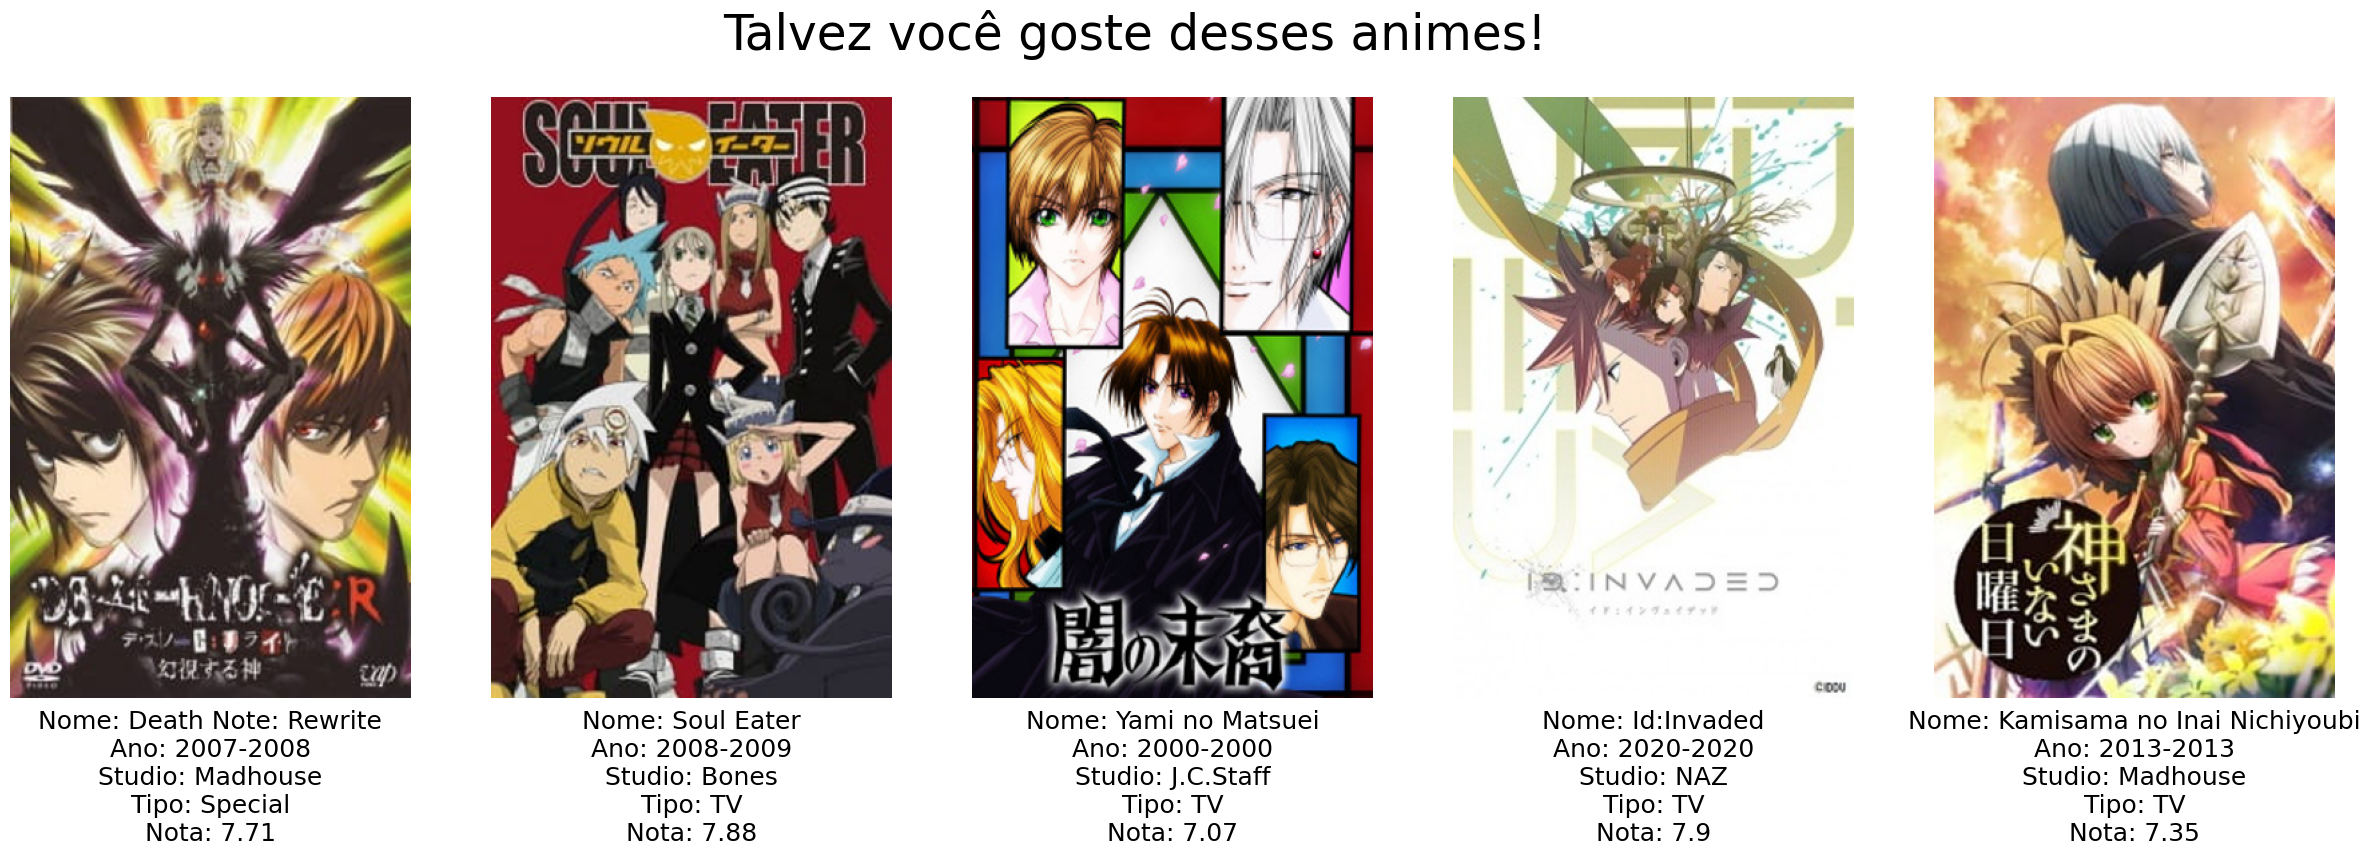

In [693]:
display_top5(df_recommended)

## Referências

[Bases de dados - Kaggle](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=anime_with_synopsis.csv)<br>
[Stemming - Quora](https://www.quora.com/What-is-stemming-NLP-Python)<br>
[Term Document Matrix - Medium](https://medium.com/analytics-vidhya/tdm-term-document-matrix-and-dtm-document-term-matrix-8b07c58957e2)<br>
[TF-IDF - Medium](https://ted-mei.medium.com/demystify-tf-idf-in-indexing-and-ranking-5c3ae88c3fa0)<br>
[Topic Modelling - FreeCodeCamp](https://www.freecodecamp.org/news/advanced-topic-modeling-how-to-use-svd-nmf-in-python/)<br>
[Non-negative Matrix Factorization - Wikipedia](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)<br>
[Content Based Recommendation System - Analytics Vidhya](https://www.analyticsvidhya.com/blog/2022/08/building-a-content-based-recommendation-system/)